# Understanding personal protective behaviours and opportunities for interventions:
## Results from a multi-method investigation of cross-sectional data
#### Kaisa Sauro, James Twose, Gjalt-Jorn Peters, Matti Heino & Nelli Hankonen

#### [Literature review of models](https://docs.google.com/document/d/129KeoFputOHx6Bp5cfi9Omz6LN3p14qjNLD3TXnFEbI/edit?usp=sharing)

## approaches used here: _Linear Regression_, _Logistic Regression_, _Partial correlations_, _SEM_ 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, RepeatedStratifiedKFold, RepeatedKFold

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression

In [4]:
from sklearn.model_selection import KFold

In [5]:
import statsmodels.api as sm

In [6]:
from semopy import Model, semplot, report
from semopy.examples import political_democracy

In [7]:
import itertools

In [8]:
from jmspack.frequentist_statistics import (correlation_analysis,
                                            potential_for_change_index,
                                            multiple_univariate_OLSs,
                                            correct_pvalues,
                                            partial_correlation
                                           )
from jmspack.utils import (flatten,
                           apply_scaling,
                           JmsColors
                          )

In [9]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

# _ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [10]:
session_info.show(req_file_name="corona_preppers-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [11]:
df = pd.read_csv("data/shield_gjames_21-09-20_prepped.csv").drop("Unnamed: 0", axis=1)

In [12]:
df.head()

,id,sampling_weight,demographic_gender,demographic_age,demographic_4_areas,demographic_8_areas,demographic_higher_education,behaviour_indoors_nonhouseholders,behaviour_close_contact,behaviour_quarantined,...,intention_public_transport_recoded,intention_indoor_meeting_recoded,intention_restaurant_recoded,intention_pa_recoded,intention_composite,behaviour_indoors_nonhouseholders_recoded,behaviour_unmasked_recoded,behavior_composite,behavior_composite_recoded,intention_behavior_composite
0,1,2.060959,2,60+,2,7,0,2,5,2,...,0,0,0,0,0,1.000000,0.000000,0.000000,0.000000,0.000000
1,2,1.784139,2,40-49,1,1,1,3,3,2,...,0,1,1,1,3,0.785714,0.214286,0.168367,0.841837,1.920918
2,3,1.204000,1,60+,1,2,1,4,4,2,...,0,0,0,0,0,0.500000,0.214286,0.107143,0.535714,0.267857
3,4,2.232220,1,60+,2,6,0,4,3,2,...,0,2,0,2,4,0.500000,0.500000,0.250000,1.250000,2.625000
4,5,1.627940,2,18-29,1,3,0,6,3,2,...,0,2,0,0,2,0.000000,0.214286,0.000000,0.000000,1.000000


In [13]:
sdt_columns = df.filter(regex="sdt").columns.tolist()

In [14]:
drop_sdt = True
if drop_sdt:
    df=df.drop(sdt_columns, axis=1)

In [15]:
df.shape

(2272, 87)

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [16]:
target = "intention_behavior_composite"

In [17]:
df[target] = (df[target] - 10) * -1

In [18]:
features_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective").columns.tolist()

In [19]:
meta_columns = ['Original position', 'Variable name', 'Label',
       'Item english translation', 'Label short', 'Type', 'New variable name',
       'variable name helper',
       'Of primary interest as a predictor (i.e. feature)?', 'English lo-anchor',
       'English hi-anchor']

In [20]:
meta_df = pd.read_excel("metadata/questionLabels.xlsx").loc[:, meta_columns]

In [21]:
meta_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective|^behaviour|^intention").columns.tolist()

In [22]:
pd.set_option("display.max_colwidth", 350)
pd.set_option('display.expand_frame_repr', True)
# meta_df.loc[meta_df["New variable name"].isin(meta_list), ["Item english translation", "New variable name"]]

In [23]:
pd.set_option("display.max_colwidth", 100)

## EDA on the target
Check the amount of samples in the target

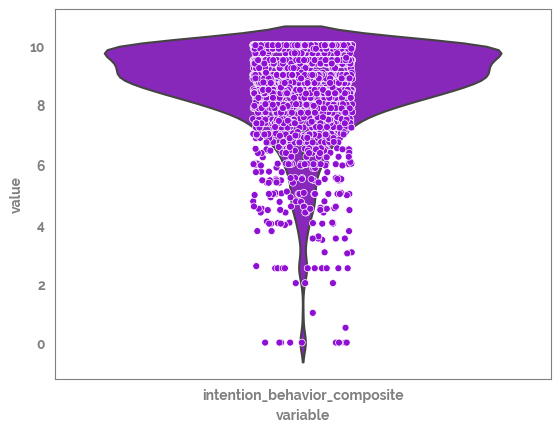

In [24]:
_ = sns.violinplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value"
               )
_ = sns.stripplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value",
                  edgecolor='white',
                  linewidth=0.5
               )

In [25]:
pd.crosstab(df["demographic_gender"], df["demographic_age"])

demographic_age,18-29,30-39,40-49,50-59,60+
demographic_gender,,,,,
1,114,169,187,168,337
2,281,185,229,211,391


In [26]:
target_df = df[target]
target_df.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
intention_behavior_composite,2272.0,8.582428,1.524704,-0.0,8.017857,8.964286,9.5,10.0


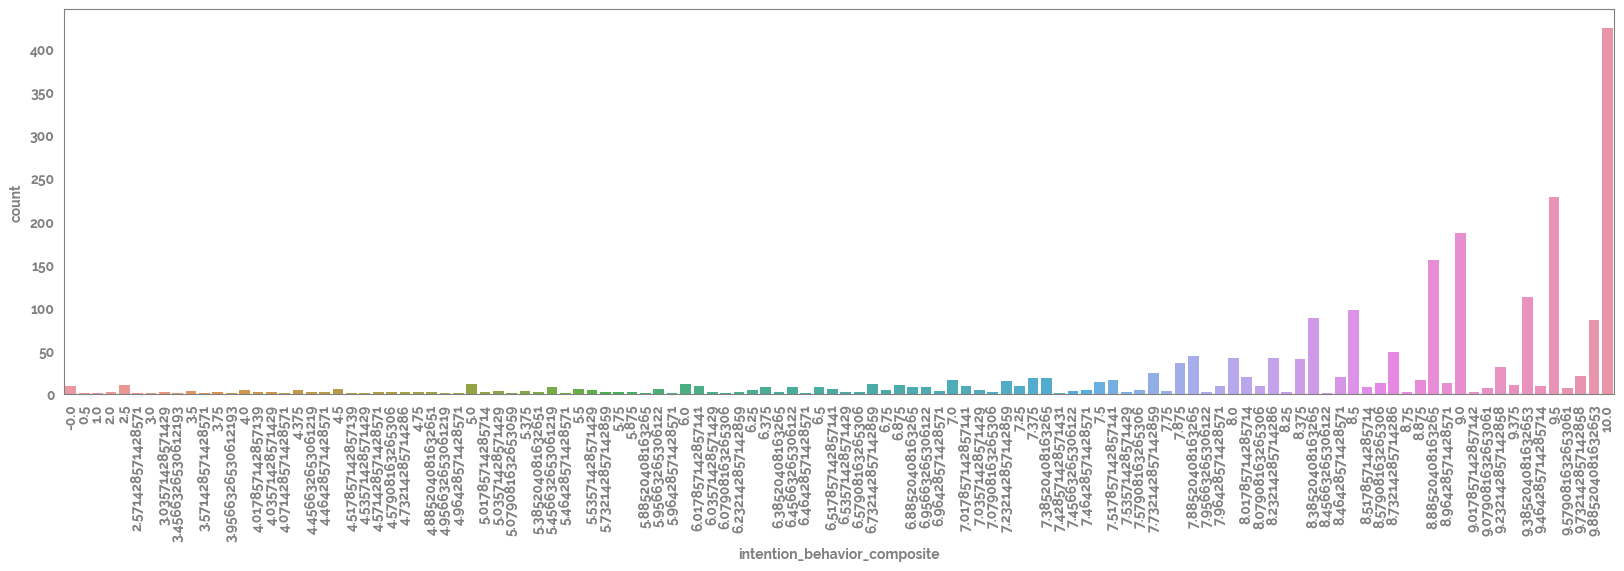

In [27]:
_ = plt.figure(figsize=(20, 5))
_ = sns.countplot(x=target_df)
_ = plt.xticks(rotation=90)

In [28]:
df = (df[["demographic_age", "demographic_higher_education"] + features_list + [target]])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   demographic_age                   2272 non-null   object 
 1   demographic_higher_education      2272 non-null   int64  
 2   automaticity_carry_mask           2272 non-null   int64  
 3   automaticity_put_on_mask          2272 non-null   int64  
 4   inst_attitude_protects_self       2272 non-null   int64  
 5   inst_attitude_protects_others     2272 non-null   int64  
 6   inst_attitude_sense_of_community  2272 non-null   int64  
 7   inst_attitude_enough_oxygen       2272 non-null   int64  
 8   inst_attitude_no_needless_waste   2272 non-null   int64  
 9   norms_family_friends              2272 non-null   int64  
 10  norms_risk_groups                 2272 non-null   int64  
 11  norms_officials                   2272 non-null   int64  
 12  norms_

In [30]:
display(df[target].value_counts().head().to_frame()), df.shape[0], df[target].value_counts().head().sum()

,intention_behavior_composite
10.000000,424
9.500000,228
9.000000,187
8.885204,155
9.385204,112


(None, 2272, 1106)

## Multivariate Linear Regression

In [31]:
X = df[features_list]
y = df[target]

In [32]:
mod = sm.OLS(endog=y, exog=X)
res = mod.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              4050.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3705.8
No. Observations:                          2272   AIC:                                      7466.
Df Residuals:                              2245   BIC:                                      7620.
Df Model:                                    27                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0923      0.031      2.933      0.003       0.031       0.154
automaticity_put_on_mask             0.0787      0.034      2.331      0.020       0.012       0.145
inst_attitude_protects_self         -0.0120      0.024     -0.491      0.624      -0.060       0.036
inst_attitude_protects_others        0.2237      0.032      6.901      0.000       0.160       0.287
inst_attitude_sense_of_community    -0.0035      0.020     -0.173      0.863      -0.043       0.036
inst_attitude_enough_oxygen          0.1177      0.021      5.668      0.000       0.077       0.158
inst_attitude_no_needless_waste      0.0190      0.016      1.172      0.241      -0.013       0.051
norms_family_friends                 0.0758      0.027      2.840      0.005       0.023       0.128
norms_risk_groups                -4.061e-05      0.034     -0.001      0.999      -0.067       0.067
norms_officials                      0.1520      0.032      4.817      0.000       0.090       0.214
norms_people_present_indoors         0.1691      0.024      7.160      0.000       0.123       0.215
aff_attitude_comfortable             0.0224      0.029      0.778      0.437      -0.034       0.079
aff_attitude_calm                    0.0316      0.027      1.192      0.233      -0.020       0.084
aff_attitude_safe                    0.0213      0.031      0.688      0.492      -0.039       0.082
aff_attitude_responsible             0.0120      0.033      0.363      0.717      -0.053       0.077
aff_attitude_difficult_breathing     0.1773      0.019      9.375      0.000       0.140       0.214
effective_means_handwashing          0.0465      0.021      2.170      0.030       0.004       0.089
effective_means_masks                0.0202      0.028      0.721      0.471      -0.035       0.075
effective_means_distance             0.1063      0.026      4.127      0.000       0.056       0.157
effective_means_ventilation          0.0497      0.020      2.507      0.012       0.011       0.089
risk_likely_contagion                0.0551      0.023      2.344      0.019       0.009       0.101
risk_contagion_absent_protection     0.0012      0.020      0.062      0.951      -0.038       0.040
risk_severity                        0.1452      0.021      6.893      0.000       0.104       0.187
risk_fear_spread                     0.0224      0.026      0.848      0.396      -0.029       0.074
risk_fear_contagion_self            -0.0313      0.026     -1.206      0.228      -0.082       0.020
risk_fear_contagion_others          -0.0046   

## Stepwise/ RFE multivariate linear regressions

In [33]:
X = df[features_list]
y = df[target]

sig_cutoff = 0.05
new_features_list = features_list
while len(res.pvalues[res.pvalues > sig_cutoff]):
    drop_feature = res.pvalues[res.pvalues > 0.05].sort_values().tail(1).index.values[0]
    new_features_list = df[new_features_list].drop(drop_feature, axis=1).columns.tolist()
    X = df[new_features_list]
    mod = sm.OLS(endog=y, exog=X)
    res = mod.fit()
    display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              4208.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3705.8
No. Observations:                          2272   AIC:                                      7464.
Df Residuals:                              2246   BIC:                                      7613.
Df Model:                                    26                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0923      0.031      2.934      0.003       0.031       0.154
automaticity_put_on_mask             0.0787      0.034      2.332      0.020       0.013       0.145
inst_attitude_protects_self         -0.0120      0.024     -0.491      0.624      -0.060       0.036
inst_attitude_protects_others        0.2237      0.032      6.903      0.000       0.160       0.287
inst_attitude_sense_of_community    -0.0035      0.020     -0.173      0.863      -0.043       0.036
inst_attitude_enough_oxygen          0.1177      0.021      5.687      0.000       0.077       0.158
inst_attitude_no_needless_waste      0.0190      0.016      1.173      0.241      -0.013       0.051
norms_family_friends                 0.0757      0.025      3.085      0.002       0.028       0.124
norms_officials                      0.1520      0.029      5.186      0.000       0.095       0.209
norms_people_present_indoors         0.1691      0.023      7.271      0.000       0.123       0.215
aff_attitude_comfortable             0.0224      0.029      0.778      0.436      -0.034       0.079
aff_attitude_calm                    0.0316      0.027      1.193      0.233      -0.020       0.084
aff_attitude_safe                    0.0213      0.031      0.688      0.491      -0.039       0.082
aff_attitude_responsible             0.0120      0.033      0.364      0.716      -0.052       0.076
aff_attitude_difficult_breathing     0.1773      0.019      9.389      0.000       0.140       0.214
effective_means_handwashing          0.0465      0.021      2.172      0.030       0.005       0.089
effective_means_masks                0.0202      0.028      0.724      0.469      -0.034       0.075
effective_means_distance             0.1063      0.026      4.130      0.000       0.056       0.157
effective_means_ventilation          0.0497      0.020      2.508      0.012       0.011       0.089
risk_likely_contagion                0.0551      0.023      2.347      0.019       0.009       0.101
risk_contagion_absent_protection     0.0012      0.020      0.062      0.951      -0.038       0.040
risk_severity                        0.1452      0.021      6.897      0.000       0.104       0.187
risk_fear_spread                     0.0224      0.026      0.849      0.396      -0.029       0.074
risk_fear_contagion_self            -0.0313      0.026     -1.207      0.228      -0.082       0.020
risk_fear_contagion_others          -0.0046      0.025     -0.185      0.853      -0.053       0.044
risk_fear_restrictions               0.0210   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              4378.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3705.8
No. Observations:                          2272   AIC:                                      7462.
Df Residuals:                              2247   BIC:                                      7605.
Df Model:                                    25                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0924      0.031      2.940      0.003       0.031       0.154
automaticity_put_on_mask             0.0787      0.034      2.333      0.020       0.013       0.145
inst_attitude_protects_self         -0.0121      0.024     -0.494      0.622      -0.060       0.036
inst_attitude_protects_others        0.2237      0.032      6.906      0.000       0.160       0.287
inst_attitude_sense_of_community    -0.0034      0.020     -0.171      0.865      -0.043       0.036
inst_attitude_enough_oxygen          0.1176      0.021      5.701      0.000       0.077       0.158
inst_attitude_no_needless_waste      0.0190      0.016      1.173      0.241      -0.013       0.051
norms_family_friends                 0.0758      0.024      3.096      0.002       0.028       0.124
norms_officials                      0.1520      0.029      5.187      0.000       0.095       0.209
norms_people_present_indoors         0.1691      0.023      7.272      0.000       0.124       0.215
aff_attitude_comfortable             0.0225      0.029      0.782      0.435      -0.034       0.079
aff_attitude_calm                    0.0316      0.026      1.194      0.233      -0.020       0.084
aff_attitude_safe                    0.0214      0.031      0.692      0.489      -0.039       0.082
aff_attitude_responsible             0.0120      0.033      0.365      0.715      -0.052       0.076
aff_attitude_difficult_breathing     0.1773      0.019      9.395      0.000       0.140       0.214
effective_means_handwashing          0.0465      0.021      2.173      0.030       0.005       0.089
effective_means_masks                0.0203      0.028      0.731      0.465      -0.034       0.075
effective_means_distance             0.1063      0.026      4.131      0.000       0.056       0.157
effective_means_ventilation          0.0497      0.020      2.510      0.012       0.011       0.089
risk_likely_contagion                0.0556      0.022      2.585      0.010       0.013       0.098
risk_severity                        0.1452      0.021      6.898      0.000       0.104       0.187
risk_fear_spread                     0.0226      0.026      0.861      0.390      -0.029       0.074
risk_fear_contagion_self            -0.0311      0.026     -1.206      0.228      -0.082       0.019
risk_fear_contagion_others          -0.0046      0.025     -0.186      0.853      -0.053       0.044
risk_fear_restrictions               0.0209      0.014      1.453      0.146      -0.007       0.049
==============================================

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              4562.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3705.8
No. Observations:                          2272   AIC:                                      7460.
Df Residuals:                              2248   BIC:                                      7597.
Df Model:                                    24                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0924      0.031      2.940      0.003       0.031       0.154
automaticity_put_on_mask             0.0787      0.034      2.333      0.020       0.013       0.145
inst_attitude_protects_self         -0.0123      0.024     -0.505      0.614      -0.060       0.035
inst_attitude_protects_others        0.2235      0.032      6.907      0.000       0.160       0.287
inst_attitude_enough_oxygen          0.1173      0.021      5.706      0.000       0.077       0.158
inst_attitude_no_needless_waste      0.0188      0.016      1.165      0.244      -0.013       0.051
norms_family_friends                 0.0758      0.024      3.096      0.002       0.028       0.124
norms_officials                      0.1520      0.029      5.187      0.000       0.095       0.209
norms_people_present_indoors         0.1688      0.023      7.278      0.000       0.123       0.214
aff_attitude_comfortable             0.0220      0.029      0.770      0.442      -0.034       0.078
aff_attitude_calm                    0.0316      0.026      1.194      0.232      -0.020       0.084
aff_attitude_safe                    0.0209      0.031      0.679      0.497      -0.039       0.081
aff_attitude_responsible             0.0113      0.033      0.347      0.729      -0.053       0.075
aff_attitude_difficult_breathing     0.1771      0.019      9.400      0.000       0.140       0.214
effective_means_handwashing          0.0464      0.021      2.170      0.030       0.004       0.088
effective_means_masks                0.0204      0.028      0.733      0.464      -0.034       0.075
effective_means_distance             0.1063      0.026      4.131      0.000       0.056       0.157
effective_means_ventilation          0.0498      0.020      2.515      0.012       0.011       0.089
risk_likely_contagion                0.0555      0.022      2.582      0.010       0.013       0.098
risk_severity                        0.1453      0.021      6.905      0.000       0.104       0.187
risk_fear_spread                     0.0224      0.026      0.855      0.392      -0.029       0.074
risk_fear_contagion_self            -0.0312      0.026     -1.208      0.227      -0.082       0.019
risk_fear_contagion_others          -0.0046      0.025     -0.185      0.853      -0.053       0.044
risk_fear_restrictions               0.0209      0.014      1.454      0.146      -0.007       0.049
==============================================================================
Omnibus:                      287.786   Durbin-Watson:              

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              4763.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3705.9
No. Observations:                          2272   AIC:                                      7458.
Df Residuals:                              2249   BIC:                                      7589.
Df Model:                                    23                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0923      0.031      2.939      0.003       0.031       0.154
automaticity_put_on_mask             0.0788      0.034      2.336      0.020       0.013       0.145
inst_attitude_protects_self         -0.0122      0.024     -0.499      0.618      -0.060       0.036
inst_attitude_protects_others        0.2226      0.032      6.952      0.000       0.160       0.285
inst_attitude_enough_oxygen          0.1174      0.021      5.714      0.000       0.077       0.158
inst_attitude_no_needless_waste      0.0190      0.016      1.178      0.239      -0.013       0.051
norms_family_friends                 0.0755      0.024      3.091      0.002       0.028       0.123
norms_officials                      0.1514      0.029      5.198      0.000       0.094       0.209
norms_people_present_indoors         0.1689      0.023      7.284      0.000       0.123       0.214
aff_attitude_comfortable             0.0220      0.029      0.767      0.443      -0.034       0.078
aff_attitude_calm                    0.0316      0.026      1.193      0.233      -0.020       0.084
aff_attitude_safe                    0.0210      0.031      0.684      0.494      -0.039       0.081
aff_attitude_responsible             0.0110      0.033      0.338      0.736      -0.053       0.075
aff_attitude_difficult_breathing     0.1772      0.019      9.405      0.000       0.140       0.214
effective_means_handwashing          0.0464      0.021      2.170      0.030       0.004       0.088
effective_means_masks                0.0204      0.028      0.734      0.463      -0.034       0.075
effective_means_distance             0.1059      0.026      4.131      0.000       0.056       0.156
effective_means_ventilation          0.0498      0.020      2.517      0.012       0.011       0.089
risk_likely_contagion                0.0553      0.021      2.576      0.010       0.013       0.097
risk_severity                        0.1454      0.021      6.911      0.000       0.104       0.187
risk_fear_spread                     0.0209      0.025      0.841      0.400      -0.028       0.069
risk_fear_contagion_self            -0.0325      0.025     -1.311      0.190      -0.081       0.016
risk_fear_restrictions               0.0209      0.014      1.453      0.146      -0.007       0.049
==============================================================================
Omnibus:                      287.289   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1102.311
Skew:      

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              4981.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3705.9
No. Observations:                          2272   AIC:                                      7456.
Df Residuals:                              2250   BIC:                                      7582.
Df Model:                                    22                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0924      0.031      2.942      0.003       0.031       0.154
automaticity_put_on_mask             0.0796      0.034      2.369      0.018       0.014       0.146
inst_attitude_protects_self         -0.0120      0.024     -0.494      0.622      -0.060       0.036
inst_attitude_protects_others        0.2247      0.031      7.151      0.000       0.163       0.286
inst_attitude_enough_oxygen          0.1172      0.021      5.707      0.000       0.077       0.157
inst_attitude_no_needless_waste      0.0189      0.016      1.172      0.241      -0.013       0.051
norms_family_friends                 0.0761      0.024      3.123      0.002       0.028       0.124
norms_officials                      0.1528      0.029      5.299      0.000       0.096       0.209
norms_people_present_indoors         0.1692      0.023      7.304      0.000       0.124       0.215
aff_attitude_comfortable             0.0214      0.029      0.748      0.454      -0.035       0.077
aff_attitude_calm                    0.0326      0.026      1.240      0.215      -0.019       0.084
aff_attitude_safe                    0.0243      0.029      0.835      0.404      -0.033       0.081
aff_attitude_difficult_breathing     0.1770      0.019      9.402      0.000       0.140       0.214
effective_means_handwashing          0.0470      0.021      2.201      0.028       0.005       0.089
effective_means_masks                0.0215      0.028      0.781      0.435      -0.033       0.076
effective_means_distance             0.1060      0.026      4.138      0.000       0.056       0.156
effective_means_ventilation          0.0500      0.020      2.524      0.012       0.011       0.089
risk_likely_contagion                0.0551      0.021      2.571      0.010       0.013       0.097
risk_severity                        0.1455      0.021      6.916      0.000       0.104       0.187
risk_fear_spread                     0.0211      0.025      0.852      0.394      -0.027       0.070
risk_fear_contagion_self            -0.0322      0.025     -1.298      0.194      -0.081       0.016
risk_fear_restrictions               0.0211      0.014      1.466      0.143      -0.007       0.049
==============================================================================
Omnibus:                      287.500   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1103.252
Skew:                          -0.581   Prob(JB):                    2.70e-240
Kurtosis:                       6

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              5220.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3706.0
No. Observations:                          2272   AIC:                                      7454.
Df Residuals:                              2251   BIC:                                      7574.
Df Model:                                    21                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0919      0.031      2.927      0.003       0.030       0.153
automaticity_put_on_mask             0.0799      0.034      2.376      0.018       0.014       0.146
inst_attitude_protects_others        0.2201      0.030      7.341      0.000       0.161       0.279
inst_attitude_enough_oxygen          0.1168      0.021      5.695      0.000       0.077       0.157
inst_attitude_no_needless_waste      0.0184      0.016      1.144      0.253      -0.013       0.050
norms_family_friends                 0.0751      0.024      3.094      0.002       0.028       0.123
norms_officials                      0.1532      0.029      5.316      0.000       0.097       0.210
norms_people_present_indoors         0.1691      0.023      7.299      0.000       0.124       0.214
aff_attitude_comfortable             0.0206      0.029      0.721      0.471      -0.035       0.076
aff_attitude_calm                    0.0337      0.026      1.284      0.199      -0.018       0.085
aff_attitude_safe                    0.0216      0.029      0.755      0.450      -0.034       0.078
aff_attitude_difficult_breathing     0.1763      0.019      9.394      0.000       0.139       0.213
effective_means_handwashing          0.0466      0.021      2.187      0.029       0.005       0.088
effective_means_masks                0.0199      0.027      0.728      0.467      -0.034       0.074
effective_means_distance             0.1059      0.026      4.136      0.000       0.056       0.156
effective_means_ventilation          0.0501      0.020      2.533      0.011       0.011       0.089
risk_likely_contagion                0.0559      0.021      2.615      0.009       0.014       0.098
risk_severity                        0.1447      0.021      6.900      0.000       0.104       0.186
risk_fear_spread                     0.0213      0.025      0.860      0.390      -0.027       0.070
risk_fear_contagion_self            -0.0324      0.025     -1.307      0.191      -0.081       0.016
risk_fear_restrictions               0.0210      0.014      1.459      0.145      -0.007       0.049
==============================================================================
Omnibus:                      288.080   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1106.001
Skew:                          -0.582   Prob(JB):                    6.84e-241
Kurtosis:                       6.214   Cond. No.                         39.2
=======================================================

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              5482.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3706.3
No. Observations:                          2272   AIC:                                      7453.
Df Residuals:                              2252   BIC:                                      7567.
Df Model:                                    20                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0925      0.031      2.950      0.003       0.031       0.154
automaticity_put_on_mask             0.0804      0.034      2.392      0.017       0.014       0.146
inst_attitude_protects_others        0.2198      0.030      7.333      0.000       0.161       0.279
inst_attitude_enough_oxygen          0.1204      0.020      6.043      0.000       0.081       0.159
inst_attitude_no_needless_waste      0.0194      0.016      1.212      0.226      -0.012       0.051
norms_family_friends                 0.0760      0.024      3.132      0.002       0.028       0.124
norms_officials                      0.1525      0.029      5.297      0.000       0.096       0.209
norms_people_present_indoors         0.1695      0.023      7.318      0.000       0.124       0.215
aff_attitude_calm                    0.0409      0.024      1.686      0.092      -0.007       0.088
aff_attitude_safe                    0.0241      0.028      0.849      0.396      -0.032       0.080
aff_attitude_difficult_breathing     0.1745      0.019      9.383      0.000       0.138       0.211
effective_means_handwashing          0.0474      0.021      2.228      0.026       0.006       0.089
effective_means_masks                0.0205      0.027      0.749      0.454      -0.033       0.074
effective_means_distance             0.1055      0.026      4.122      0.000       0.055       0.156
effective_means_ventilation          0.0505      0.020      2.555      0.011       0.012       0.089
risk_likely_contagion                0.0573      0.021      2.691      0.007       0.016       0.099
risk_severity                        0.1441      0.021      6.877      0.000       0.103       0.185
risk_fear_spread                     0.0214      0.025      0.866      0.387      -0.027       0.070
risk_fear_contagion_self            -0.0326      0.025     -1.319      0.187      -0.081       0.016
risk_fear_restrictions               0.0209      0.014      1.453      0.146      -0.007       0.049
==============================================================================
Omnibus:                      286.987   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1103.279
Skew:                          -0.579   Prob(JB):                    2.67e-240
Kurtosis:                       6.211   Cond. No.                         38.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model doe

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              5772.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3706.6
No. Observations:                          2272   AIC:                                      7451.
Df Residuals:                              2253   BIC:                                      7560.
Df Model:                                    19                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0933      0.031      2.975      0.003       0.032       0.155
automaticity_put_on_mask             0.0826      0.033      2.469      0.014       0.017       0.148
inst_attitude_protects_others        0.2252      0.029      7.745      0.000       0.168       0.282
inst_attitude_enough_oxygen          0.1199      0.020      6.023      0.000       0.081       0.159
inst_attitude_no_needless_waste      0.0205      0.016      1.282      0.200      -0.011       0.052
norms_family_friends                 0.0773      0.024      3.196      0.001       0.030       0.125
norms_officials                      0.1519      0.029      5.277      0.000       0.095       0.208
norms_people_present_indoors         0.1708      0.023      7.399      0.000       0.126       0.216
aff_attitude_calm                    0.0408      0.024      1.685      0.092      -0.007       0.088
aff_attitude_safe                    0.0269      0.028      0.959      0.338      -0.028       0.082
aff_attitude_difficult_breathing     0.1731      0.019      9.356      0.000       0.137       0.209
effective_means_handwashing          0.0475      0.021      2.233      0.026       0.006       0.089
effective_means_distance             0.1117      0.024      4.603      0.000       0.064       0.159
effective_means_ventilation          0.0506      0.020      2.558      0.011       0.012       0.089
risk_likely_contagion                0.0573      0.021      2.693      0.007       0.016       0.099
risk_severity                        0.1450      0.021      6.932      0.000       0.104       0.186
risk_fear_spread                     0.0234      0.025      0.953      0.341      -0.025       0.072
risk_fear_contagion_self            -0.0329      0.025     -1.331      0.183      -0.081       0.016
risk_fear_restrictions               0.0194      0.014      1.361      0.174      -0.009       0.047
==============================================================================
Omnibus:                      286.047   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1090.649
Skew:                          -0.580   Prob(JB):                    1.47e-237
Kurtosis:                       6.190   Cond. No.                         37.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is corr

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              6093.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3707.0
No. Observations:                          2272   AIC:                                      7450.
Df Residuals:                              2254   BIC:                                      7553.
Df Model:                                    18                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0940      0.031      2.999      0.003       0.033       0.155
automaticity_put_on_mask             0.0825      0.033      2.466      0.014       0.017       0.148
inst_attitude_protects_others        0.2281      0.029      7.887      0.000       0.171       0.285
inst_attitude_enough_oxygen          0.1196      0.020      6.010      0.000       0.081       0.159
inst_attitude_no_needless_waste      0.0201      0.016      1.258      0.209      -0.011       0.051
norms_family_friends                 0.0787      0.024      3.257      0.001       0.031       0.126
norms_officials                      0.1530      0.029      5.323      0.000       0.097       0.209
norms_people_present_indoors         0.1709      0.023      7.404      0.000       0.126       0.216
aff_attitude_calm                    0.0398      0.024      1.644      0.100      -0.008       0.087
aff_attitude_safe                    0.0292      0.028      1.045      0.296      -0.026       0.084
aff_attitude_difficult_breathing     0.1721      0.018      9.316      0.000       0.136       0.208
effective_means_handwashing          0.0472      0.021      2.216      0.027       0.005       0.089
effective_means_distance             0.1124      0.024      4.636      0.000       0.065       0.160
effective_means_ventilation          0.0509      0.020      2.574      0.010       0.012       0.090
risk_likely_contagion                0.0594      0.021      2.803      0.005       0.018       0.101
risk_severity                        0.1449      0.021      6.924      0.000       0.104       0.186
risk_fear_contagion_self            -0.0184      0.019     -0.944      0.345      -0.057       0.020
risk_fear_restrictions               0.0192      0.014      1.346      0.178      -0.009       0.047
==============================================================================
Omnibus:                      287.168   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1088.350
Skew:                          -0.584   Prob(JB):                    4.65e-237
Kurtosis:                       6.183   Cond. No.                         36.6
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              6452.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3707.5
No. Observations:                          2272   AIC:                                      7449.
Df Residuals:                              2255   BIC:                                      7546.
Df Model:                                    17                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0926      0.031      2.957      0.003       0.031       0.154
automaticity_put_on_mask             0.0827      0.033      2.472      0.014       0.017       0.148
inst_attitude_protects_others        0.2266      0.029      7.847      0.000       0.170       0.283
inst_attitude_enough_oxygen          0.1201      0.020      6.038      0.000       0.081       0.159
inst_attitude_no_needless_waste      0.0199      0.016      1.247      0.213      -0.011       0.051
norms_family_friends                 0.0772      0.024      3.203      0.001       0.030       0.124
norms_officials                      0.1533      0.029      5.331      0.000       0.097       0.210
norms_people_present_indoors         0.1697      0.023      7.364      0.000       0.125       0.215
aff_attitude_calm                    0.0414      0.024      1.716      0.086      -0.006       0.089
aff_attitude_safe                    0.0277      0.028      0.991      0.322      -0.027       0.082
aff_attitude_difficult_breathing     0.1733      0.018      9.404      0.000       0.137       0.209
effective_means_handwashing          0.0476      0.021      2.235      0.025       0.006       0.089
effective_means_distance             0.1130      0.024      4.661      0.000       0.065       0.161
effective_means_ventilation          0.0501      0.020      2.538      0.011       0.011       0.089
risk_likely_contagion                0.0562      0.021      2.688      0.007       0.015       0.097
risk_severity                        0.1339      0.017      7.682      0.000       0.100       0.168
risk_fear_restrictions               0.0191      0.014      1.340      0.180      -0.009       0.047
==============================================================================
Omnibus:                      286.019   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1081.242
Skew:                          -0.582   Prob(JB):                    1.63e-235
Kurtosis:                       6.173   Cond. No.                         35.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              6855.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3708.0
No. Observations:                          2272   AIC:                                      7448.
Df Residuals:                              2256   BIC:                                      7540.
Df Model:                                    16                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0942      0.031      3.012      0.003       0.033       0.155
automaticity_put_on_mask             0.0829      0.033      2.479      0.013       0.017       0.149
inst_attitude_protects_others        0.2327      0.028      8.247      0.000       0.177       0.288
inst_attitude_enough_oxygen          0.1211      0.020      6.091      0.000       0.082       0.160
inst_attitude_no_needless_waste      0.0214      0.016      1.344      0.179      -0.010       0.053
norms_family_friends                 0.0781      0.024      3.245      0.001       0.031       0.125
norms_officials                      0.1555      0.029      5.424      0.000       0.099       0.212
norms_people_present_indoors         0.1705      0.023      7.402      0.000       0.125       0.216
aff_attitude_calm                    0.0481      0.023      2.072      0.038       0.003       0.094
aff_attitude_difficult_breathing     0.1737      0.018      9.432      0.000       0.138       0.210
effective_means_handwashing          0.0489      0.021      2.300      0.022       0.007       0.091
effective_means_distance             0.1153      0.024      4.782      0.000       0.068       0.163
effective_means_ventilation          0.0497      0.020      2.515      0.012       0.011       0.088
risk_likely_contagion                0.0555      0.021      2.655      0.008       0.015       0.097
risk_severity                        0.1357      0.017      7.823      0.000       0.102       0.170
risk_fear_restrictions               0.0182      0.014      1.280      0.201      -0.010       0.046
==============================================================================
Omnibus:                      283.656   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1064.353
Skew:                          -0.579   Prob(JB):                    7.56e-232
Kurtosis:                       6.147   Cond. No.                         34.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              7310.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3708.8
No. Observations:                          2272   AIC:                                      7448.
Df Residuals:                              2257   BIC:                                      7534.
Df Model:                                    15                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0921      0.031      2.949      0.003       0.031       0.153
automaticity_put_on_mask             0.0839      0.033      2.508      0.012       0.018       0.150
inst_attitude_protects_others        0.2334      0.028      8.272      0.000       0.178       0.289
inst_attitude_enough_oxygen          0.1227      0.020      6.188      0.000       0.084       0.162
inst_attitude_no_needless_waste      0.0187      0.016      1.188      0.235      -0.012       0.050
norms_family_friends                 0.0763      0.024      3.172      0.002       0.029       0.123
norms_officials                      0.1627      0.028      5.789      0.000       0.108       0.218
norms_people_present_indoors         0.1692      0.023      7.352      0.000       0.124       0.214
aff_attitude_calm                    0.0470      0.023      2.027      0.043       0.002       0.092
aff_attitude_difficult_breathing     0.1803      0.018     10.184      0.000       0.146       0.215
effective_means_handwashing          0.0499      0.021      2.350      0.019       0.008       0.092
effective_means_distance             0.1153      0.024      4.781      0.000       0.068       0.163
effective_means_ventilation          0.0508      0.020      2.575      0.010       0.012       0.089
risk_likely_contagion                0.0582      0.021      2.797      0.005       0.017       0.099
risk_severity                        0.1347      0.017      7.772      0.000       0.101       0.169
==============================================================================
Omnibus:                      278.533   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1032.141
Skew:                          -0.571   Prob(JB):                    7.47e-225
Kurtosis:                       6.098   Cond. No.                         34.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              7830.
Date:                          Sun, 12 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  14:23:28   Log-Likelihood:                         -3709.5
No. Observations:                          2272   AIC:                                      7447.
Df Residuals:                              2258   BIC:                                      7527.
Df Model:                                    14                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0943      0.031      3.026      0.003       0.033       0.155
automaticity_put_on_mask             0.0850      0.033      2.542      0.011       0.019       0.151
inst_attitude_protects_others        0.2346      0.028      8.321      0.000       0.179       0.290
inst_attitude_enough_oxygen          0.1254      0.020      6.359      0.000       0.087       0.164
norms_family_friends                 0.0780      0.024      3.252      0.001       0.031       0.125
norms_officials                      0.1608      0.028      5.730      0.000       0.106       0.216
norms_people_present_indoors         0.1693      0.023      7.354      0.000       0.124       0.214
aff_attitude_calm                    0.0504      0.023      2.190      0.029       0.005       0.096
aff_attitude_difficult_breathing     0.1797      0.018     10.156      0.000       0.145       0.214
effective_means_handwashing          0.0494      0.021      2.326      0.020       0.008       0.091
effective_means_distance             0.1170      0.024      4.860      0.000       0.070       0.164
effective_means_ventilation          0.0513      0.020      2.601      0.009       0.013       0.090
risk_likely_contagion                0.0570      0.021      2.742      0.006       0.016       0.098
risk_severity                        0.1391      0.017      8.216      0.000       0.106       0.172
==============================================================================
Omnibus:                      276.781   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1013.318
Skew:                          -0.571   Prob(JB):                    9.14e-221
Kurtosis:                       6.066   Cond. No.                         33.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## SEM

In [34]:
# automaticity|attitude|^norms|^risk|^effective

In [35]:
aut = df.filter(regex="automaticity").columns.tolist()
att = df.filter(regex="attitude").columns.tolist()
nor = df.filter(regex="^norms").columns.tolist()
ris = df.filter(regex="^risk").columns.tolist()
eff = df.filter(regex="^effective").columns.tolist()

In [36]:
aut_corrs = '\n'.join([' ~~ '.join(x) for x in itertools.combinations(aut, 2)])
att_corrs = '\n'.join([' ~~ '.join(x) for x in itertools.combinations(att, 2)])
nor_corrs = '\n'.join([' ~~ '.join(x) for x in itertools.combinations(nor, 2)])
ris_corrs = '\n'.join([' ~~ '.join(x) for x in itertools.combinations(ris, 2)])
eff_corrs = '\n'.join([' ~~ '.join(x) for x in itertools.combinations(eff, 2)])

In [37]:
desc = f"""
# measurement model
automaticity =~ {' + '.join(aut)}
attitude =~ {' + '.join(att)}
norms =~ {' + '.join(nor)}
risk =~ {' + '.join(ris)}
effective =~ {' + '.join(eff)}

# regression
{target} =~ automaticity + attitude + norms + risk + effective

# residual correlations
{aut_corrs}
{att_corrs}
{nor_corrs}
{ris_corrs}
{eff_corrs}

"""

In [38]:
print(desc[:888])


# measurement model
automaticity =~ automaticity_carry_mask + automaticity_put_on_mask
attitude =~ inst_attitude_protects_self + inst_attitude_protects_others + inst_attitude_sense_of_community + inst_attitude_enough_oxygen + inst_attitude_no_needless_waste + aff_attitude_comfortable + aff_attitude_calm + aff_attitude_safe + aff_attitude_responsible + aff_attitude_difficult_breathing
norms =~ norms_family_friends + norms_risk_groups + norms_officials + norms_people_present_indoors
risk =~ risk_likely_contagion + risk_contagion_absent_protection + risk_severity + risk_fear_spread + risk_fear_contagion_self + risk_fear_contagion_others + risk_fear_restrictions
effective =~ effective_means_handwashing + effective_means_masks + effective_means_distance + effective_means_ventilation

# regression
intention_behavior_composite =~ automaticity + attitude + norms + risk + effective




In [39]:
mod = Model(desc)
res_opt = mod.fit(df, obj="FIML")
estimates = mod.inspect()
report(mod, "mask-behaviour-SEM")

estimates.head()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,automaticity,~,intention_behavior_composite,1.000000,-,-,-
1,attitude,~,intention_behavior_composite,0.964388,0.00631447,152.727,0
2,norms,~,intention_behavior_composite,1.056695,0.00666633,158.512,0
3,risk,~,intention_behavior_composite,0.404973,0.00508497,79.6412,0
4,effective,~,intention_behavior_composite,1.074519,0.00719135,149.418,0


In [40]:
estimates[estimates["rval"].str.contains(target)]

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,automaticity,~,intention_behavior_composite,1.000000,-,-,-
1,attitude,~,intention_behavior_composite,0.964388,0.00631447,152.727,0
2,norms,~,intention_behavior_composite,1.056695,0.00666633,158.512,0
3,risk,~,intention_behavior_composite,0.404973,0.00508497,79.6412,0
4,effective,~,intention_behavior_composite,1.074519,0.00719135,149.418,0
37,intention_behavior_composite,~~,intention_behavior_composite,32.357679,1.01117,32.0001,0


In [41]:
estimates["p-value"] = estimates["p-value"].replace("-", np.nan)

In [42]:
estimates[estimates["p-value"] < 0.05]

,lval,op,rval,Estimate,Std. Err,z-value,p-value
1,attitude,~,intention_behavior_composite,0.964388,0.00631447,152.727,0.0
2,norms,~,intention_behavior_composite,1.056695,0.00666633,158.512,0.0
3,risk,~,intention_behavior_composite,0.404973,0.00508497,79.6412,0.0
4,effective,~,intention_behavior_composite,1.074519,0.00719135,149.418,0.0
6,automaticity_put_on_mask,~,automaticity,1.021864,0.00324489,314.915,0.0
...,...,...,...,...,...,...,...
138,effective_means_distance,~~,effective_means_distance,1.327009,0.0357449,37.1244,0.0
139,risk_fear_restrictions,~~,risk_fear_restrictions,3.803706,0.135054,28.1644,0.0
140,aff_attitude_difficult_breathing,~~,aff_attitude_difficult_breathing,3.642408,0.110116,33.078,0.0
141,norms_people_present_indoors,~~,norms_people_present_indoors,1.426854,0.0398755,35.7827,0.0


In [43]:
# g = semplot(mod, filename='semplot.png')
# g

## Example political democracy SEM

In [44]:
# from semopy.examples import political_democracy
# from semopy import ModelMeans, report

# desc = political_democracy.get_model()
# data = political_democracy.get_data()
# model = ModelMeans(desc)
# model.fit(data)
# report(model, "Political Democracy")

## Spearman Correlations with FDR-BH correction

In [45]:
dict_results = correlation_analysis(data=df, 
                     col_list=features_list, 
                     row_list=[target], 
                     check_norm=False, 
                     method = 'spearman', 
                     dropna = 'pairwise'
                     )
dict_results['summary']

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
0,Spearman Rank,automaticity_carry_mask,intention_behavior_composite,0.373645,3.383126e-76,True,2272
1,Spearman Rank,automaticity_put_on_mask,intention_behavior_composite,0.364111,3.578368e-72,True,2272
2,Spearman Rank,inst_attitude_protects_self,intention_behavior_composite,0.311923,1.871267e-52,True,2272
3,Spearman Rank,inst_attitude_protects_others,intention_behavior_composite,0.309530,1.221566e-51,True,2272
4,Spearman Rank,inst_attitude_sense_of_community,intention_behavior_composite,0.242064,1.183843e-31,True,2272
5,Spearman Rank,inst_attitude_enough_oxygen,intention_behavior_composite,0.272911,4.298332e-40,True,2272
6,Spearman Rank,inst_attitude_no_needless_waste,intention_behavior_composite,0.332918,6.244255e-60,True,2272
7,Spearman Rank,norms_family_friends,intention_behavior_composite,0.365861,6.684440e-73,True,2272
8,Spearman Rank,norms_risk_groups,intention_behavior_composite,0.263058,2.841374e-37,True,2272
9,Spearman Rank,norms_officials,intention_behavior_composite,0.183851,1.010440e-18,True,2272


In [46]:
p_values = dict_results['summary'].loc[:, "p-value"].values

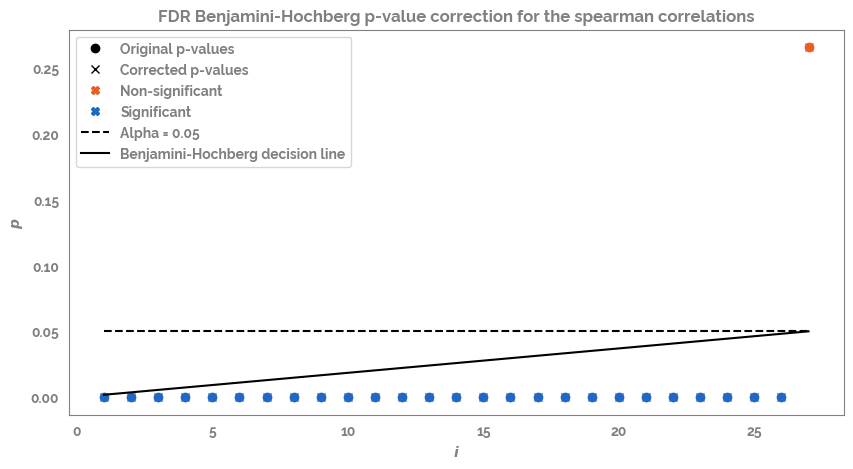

In [47]:
_ = correct_pvalues(pvals=p_values, 
                alpha = 0.05, 
                method = 'fdr_bh', 
                plot = True, 
                title = 'FDR Benjamini-Hochberg p-value correction for the spearman correlations', 
                figsize = (10, 5))

## Partial Correlations

In [48]:
partial_corr_matrix_rvals_df, partial_corr_matrix_pvals_df = partial_correlation(df=df[features_list+[target]])

In [49]:
par_cor_df = (pd.merge(partial_corr_matrix_rvals_df.loc[:, [target]], 
                       partial_corr_matrix_pvals_df.loc[:, [target]], 
                       suffixes=["_r-values", "_p-values"],
                       left_index=True, 
                       right_index=True)
              .round(4)
              .sort_values(by=f"{target}_p-values", ascending=True)
              .drop(target)
              )

In [50]:
par_cor_df.style.bar(subset=[f"{target}_r-values"], 
            align='mid', 
            color=['#d65f5f', '#5fba7d'])

,intention_behavior_composite_r-values,intention_behavior_composite_p-values
inst_attitude_protects_others,0.088200,0.000000
risk_fear_restrictions,-0.088500,0.000000
norms_people_present_indoors,0.155800,0.000000
norms_family_friends,0.090100,0.000000
risk_severity,0.121300,0.000000
automaticity_put_on_mask,0.070600,0.000800
automaticity_carry_mask,0.068500,0.001100
effective_means_masks,0.059600,0.004500
effective_means_distance,0.052600,0.012100
norms_risk_groups,-0.043800,0.036900


In [51]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
par_cor_df.style.background_gradient(cmap, 
                            subset=[f"{target}_r-values"], 
                            axis=1, 
                            vmin=-0.1, 
                            vmax=0.16)

,intention_behavior_composite_r-values,intention_behavior_composite_p-values
inst_attitude_protects_others,0.088200,0.000000
risk_fear_restrictions,-0.088500,0.000000
norms_people_present_indoors,0.155800,0.000000
norms_family_friends,0.090100,0.000000
risk_severity,0.121300,0.000000
automaticity_put_on_mask,0.070600,0.000800
automaticity_carry_mask,0.068500,0.001100
effective_means_masks,0.059600,0.004500
effective_means_distance,0.052600,0.012100
norms_risk_groups,-0.043800,0.036900
